# Spark Sales Analytics

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col , expr, first, sum, date_format, from_unixtime, unix_timestamp, lpad, hour, count, max, collect_list, size

In [2]:
spark = (SparkSession.builder.appName("SparkSalesAnalytics").getOrCreate())

## Challenge Part 3 - Sales Analytics (Self Solution)

### Read 2019 data

In [3]:
sales_data_path = "./data/output/sales/ReportYear=2019"

sales_df = (spark.read.format("parquet")
           .option("header", True)
           .option("inferSchema", True)
           .load(sales_data_path))

In [4]:
sales_df.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- OrderDate: timestamp (nullable = true)
 |-- StoreAddress: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Month: integer (nullable = true)



#### Q1 : What was the best month in terms of sales?

In [5]:
sales_df.where(col("Quantity") > 1).show(5,False)

+-------+----------------------+--------+-----+-------------------+-----------------------------------+-------------+-----+-----+
|OrderID|Product               |Quantity|Price|OrderDate          |StoreAddress                       |City         |State|Month|
+-------+----------------------+--------+-----+-------------------+-----------------------------------+-------------+-----+-----+
|295672 |USB-C Charging Cable  |2       |11.95|2019-12-13 09:29:00|813 Hickory St, Dallas, TX 75001   |Dallas       |TX   |12   |
|295674 |AAA Batteries (4-pack)|4       |2.99 |2019-12-28 11:51:00|77 7th St, Dallas, TX 75001        |Dallas       |TX   |12   |
|295675 |USB-C Charging Cable  |2       |11.95|2019-12-13 13:52:00|594 1st St, San Francisco, CA 94016|San Francisco|CA   |12   |
|295677 |AA Batteries (4-pack) |2       |3.84 |2019-12-20 19:19:00|866 Pine St, Boston, MA 02215      |Boston       |MA   |12   |
|295678 |AAA Batteries (4-pack)|2       |2.99 |2019-12-06 09:38:00|187 Lincoln St, Dallas,

In [6]:
top_sales_month = (sales_df.groupBy("Month")
                     .agg(sum(expr("Quantity * Price")).alias("Total Sales"))
                     .orderBy("Total Sales", ascending = False)
                    ).select(from_unixtime(unix_timestamp(lpad(col("Month").cast(StringType()),2,'0'),'MM'),'MMMM')).collect()[0][0]
print(top_sales_month, "was the best month in terms of sales in 2019")

December was the best month in terms of sales in 2019


#### Q2 : Which city actually sold the most products?

In [7]:
most_products_sold_city = (sales_df.groupBy("City")
                                     .agg(sum("Quantity").alias("Total Products Sold"))
                                     .orderBy("Total Products Sold", ascending = False)
                            ).collect()[0][0]
print(most_products_sold_city, "was the city that actually sold the most products in 2019")

San Francisco was the city that actually sold the most products in 2019


#### Q3 : What time should we display advertisements to maximize the likelihood of customers buying products?

In [8]:
hour_in_which_most_orders_placed = (sales_df.groupBy(hour("OrderDate").alias("OrderHour"))
                                             .agg(count("OrderID").alias("TotalOrdersForTheYear"))
                                             .orderBy("TotalOrdersForTheYear",ascending=False)
                                    ).select(from_unixtime(unix_timestamp(lpad(col("OrderHour").cast(StringType()),2,'0'),'HH'),"hh a")).collect()[0][0]
print("Advertisements can be displayed around", hour_in_which_most_orders_placed, "to maximize the likelihood of customers buying products.")

Advertisements can be displayed around 07 PM to maximize the likelihood of customers buying products.


#### Q4 : What products are often sold together in the state of "NY"?

In [9]:
print("The following sets of items are the top 3 sets often bought together (shown alongside are the number of times they have been exclusively ordered in 2019) - ")
(sales_df.where(col("State") == "NY")
         .groupBy("OrderID")
         .agg(collect_list("Product").alias("ProductList"))
         .where(size("ProductList")>1)
).groupBy("ProductList").agg(count("ProductList").alias("OrderedTimes")).orderBy("OrderedTimes", ascending = False).show(n=3,truncate=False)


The following sets of items are the top 3 sets often bought together (shown alongside are the number of times they have been exclusively ordered in 2019) - 
+------------------------------------+------------+
|ProductList                         |OrderedTimes|
+------------------------------------+------------+
|[iPhone, Lightning Charging Cable]  |126         |
|[Google Phone, USB-C Charging Cable]|124         |
|[Google Phone, Wired Headphones]    |52          |
+------------------------------------+------------+
only showing top 3 rows



## Challenge Part 3 - Sales Analytics (Instructor Solution)

### Read 2019 Data from the Parquet Files Directory

In [10]:
source_data_path = "./data/output/sales/"
partition = "ReportYear=2019"
full_path = f"{source_data_path}{partition}"

In [11]:
sales2019_df = spark.read.parquet(full_path)
sales2019_df.show(truncate=False)

+-------+--------------------------+--------+------+-------------------+-----------------------------------------+-------------+-----+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                             |City         |State|Month|
+-------+--------------------------+--------+------+-------------------+-----------------------------------------+-------------+-----+-----+
|295665 |Macbook Pro Laptop        |1       |1700.0|2019-12-30 00:01:00|136 Church St, New York City, NY 10001   |New York City|NY   |12   |
|295666 |LG Washing Machine        |1       |600.0 |2019-12-29 07:03:00|562 2nd St, New York City, NY 10001      |New York City|NY   |12   |
|295667 |USB-C Charging Cable      |1       |11.95 |2019-12-12 18:21:00|277 Main St, New York City, NY 10001     |New York City|NY   |12   |
|295668 |27in FHD Monitor          |1       |149.99|2019-12-22 15:13:00|410 6th St, San Francisco, CA 94016      |San Francisco|CA   |12   |
|295669 |USB-

### What was the best month in sales?

In [12]:
from pyspark.sql.functions import round,sum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sales_q1_df = ( sales2019_df.select(
                                col("OrderID"),
                                col("Month"),
                                col("Price"),
                                col("Quantity"),
                                expr("Price * Quantity").alias("Sales")
                             )
               )

In [14]:
sales_q1_df.show(10)

+-------+-----+------+--------+------+
|OrderID|Month| Price|Quantity| Sales|
+-------+-----+------+--------+------+
| 295665|   12|1700.0|       1|1700.0|
| 295666|   12| 600.0|       1| 600.0|
| 295667|   12| 11.95|       1| 11.95|
| 295668|   12|149.99|       1|149.99|
| 295669|   12| 11.95|       1| 11.95|
| 295670|   12|  3.84|       1|  3.84|
| 295671|   12| 11.95|       1| 11.95|
| 295672|   12| 11.95|       2|  23.9|
| 295673|   12| 99.99|       1| 99.99|
| 295674|   12|  2.99|       4| 11.96|
+-------+-----+------+--------+------+
only showing top 10 rows



In [15]:
sales_q1_df = (sales_q1_df
              .groupBy("Month")
              .agg(round(sum("Sales"),2).alias("TotalSales"))
              .orderBy("TotalSales", ascending = False))

In [16]:
sales_q1_df.show(10)

+-----+----------+
|Month|TotalSales|
+-----+----------+
|   12|4613443.32|
|   10|3736726.86|
|    4|3390670.22|
|   11|3199603.18|
|    5|3152606.73|
|    3|2807100.37|
|    7|2647775.75|
|    6|2577802.25|
|    8|2244467.87|
|    2|2202022.41|
+-----+----------+
only showing top 10 rows



In [17]:
pd_sales_q1 = (sales_q1_df.orderBy("Month")).toPandas()

In [18]:
pd_sales_q1

,Month,TotalSales
0,1,1813586.43
1,2,2202022.41
2,3,2807100.37
3,4,3390670.22
4,5,3152606.73
5,6,2577802.25
6,7,2647775.75
7,8,2244467.87
8,9,2097560.12
9,10,3736726.86


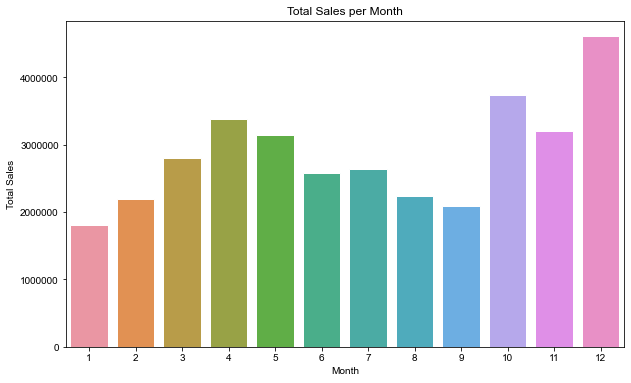

In [19]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="Month",y="TotalSales", data=pd_sales_q1).set_title("Total Sales per Month")
plt.ylabel("Total Sales")
plt.show()

### Get the city that sold the most products

In [20]:
sales2019_df.show(10)

+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|         City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...|New York City|   NY|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...|New York City|   NY|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...|New York City|   NY|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...|San Francisco|   CA|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|      Atlanta|   GA|   12|
| 295670|AA Batteries (4-p...|       1|  3.84|2019-12-31 22:58:00|200 Jefferson St,...|N

In [21]:
sales2019_df.select("OrderID","Quantity","City").show()

+-------+--------+-------------+
|OrderID|Quantity|         City|
+-------+--------+-------------+
| 295665|       1|New York City|
| 295666|       1|New York City|
| 295667|       1|New York City|
| 295668|       1|San Francisco|
| 295669|       1|      Atlanta|
| 295670|       1|New York City|
| 295671|       1|     Portland|
| 295672|       2|       Dallas|
| 295673|       1|       Dallas|
| 295674|       4|       Dallas|
| 295675|       2|San Francisco|
| 295676|       1|  Los Angeles|
| 295677|       2|       Boston|
| 295678|       2|       Dallas|
| 295679|       1|       Dallas|
| 295680|       1|       Austin|
| 295681|       1|       Boston|
| 295681|       1|       Boston|
| 295681|       1|       Boston|
| 295681|       1|       Boston|
+-------+--------+-------------+
only showing top 20 rows



In [22]:
sales_q2_df = (sales2019_df.groupBy("City")
                           .agg(sum("quantity").alias("TotalProducts"))
                           .orderBy("TotalProducts", ascending=False))

In [23]:
sales_q2_df.show(10)

+-------------+-------------+
|         City|TotalProducts|
+-------------+-------------+
|San Francisco|        50226|
|  Los Angeles|        33288|
|New York City|        27916|
|       Boston|        22524|
|       Dallas|        16728|
|      Atlanta|        16602|
|      Seattle|        16552|
|     Portland|        14051|
|       Austin|        11151|
+-------------+-------------+



In [24]:
pd_sales_q2 = sales_q2_df.toPandas()

In [25]:
pd_sales_q2

,City,TotalProducts
0,San Francisco,50226
1,Los Angeles,33288
2,New York City,27916
3,Boston,22524
4,Dallas,16728
5,Atlanta,16602
6,Seattle,16552
7,Portland,14051
8,Austin,11151


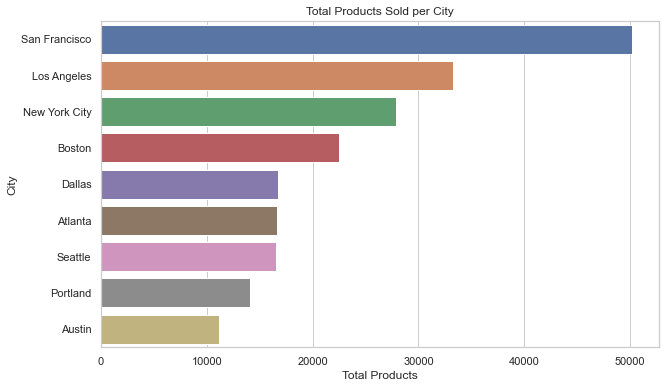

In [26]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="darkgrid")
sns.barplot(x="TotalProducts",y="City", data=pd_sales_q2).set_title("Total Products Sold per City")
plt.xlabel("Total Products")
plt.show()

### What time should we display advertisements to maximize the likelihood of customer's buying products?

In [27]:
from pyspark.sql.functions import count, date_format

In [28]:
sales2019_df.show(10,False)

+-------+--------------------------+--------+------+-------------------+-----------------------------------------+-------------+-----+-----+
|OrderID|Product                   |Quantity|Price |OrderDate          |StoreAddress                             |City         |State|Month|
+-------+--------------------------+--------+------+-------------------+-----------------------------------------+-------------+-----+-----+
|295665 |Macbook Pro Laptop        |1       |1700.0|2019-12-30 00:01:00|136 Church St, New York City, NY 10001   |New York City|NY   |12   |
|295666 |LG Washing Machine        |1       |600.0 |2019-12-29 07:03:00|562 2nd St, New York City, NY 10001      |New York City|NY   |12   |
|295667 |USB-C Charging Cable      |1       |11.95 |2019-12-12 18:21:00|277 Main St, New York City, NY 10001     |New York City|NY   |12   |
|295668 |27in FHD Monitor          |1       |149.99|2019-12-22 15:13:00|410 6th St, San Francisco, CA 94016      |San Francisco|CA   |12   |
|295669 |USB-

In [29]:
sales2019_df.groupBy("OrderID").agg(count("OrderID").alias("count")).where(col("count") > 1).show(10, False)

+-------+-----+
|OrderID|count|
+-------+-----+
|300601 |2    |
|304276 |2    |
|310188 |2    |
|261569 |2    |
|265863 |2    |
|269251 |2    |
|276515 |2    |
|277349 |2    |
|193640 |2    |
|284489 |2    |
+-------+-----+
only showing top 10 rows



In [30]:
sales2019_df.filter(col("OrderID") == 300601).show(truncate=False)

+-------+------------------------+--------+------+-------------------+---------------------------------+-----------+-----+-----+
|OrderID|Product                 |Quantity|Price |OrderDate          |StoreAddress                     |City       |State|Month|
+-------+------------------------+--------+------+-------------------+---------------------------------+-----------+-----+-----+
|300601 |Apple Airpods Headphones|1       |150.0 |2019-12-16 14:11:00|577 Elm St, Los Angeles, CA 90001|Los Angeles|CA   |12   |
|300601 |20in Monitor            |1       |109.99|2019-12-16 14:11:00|577 Elm St, Los Angeles, CA 90001|Los Angeles|CA   |12   |
+-------+------------------------+--------+------+-------------------+---------------------------------+-----------+-----+-----+



In [31]:
sales_q3_df = (sales2019_df.select("OrderID", date_format("OrderDate","HH").cast("int").alias("Hour"))
                           .distinct()
                           .groupBy("Hour")
                           .agg(count("Hour").alias("TotalOrders"))
                           .orderBy(col("TotalOrders"), ascending = False))

In [32]:
sales_q3_df.show()

+----+-----------+
|Hour|TotalOrders|
+----+-----------+
|  19|      12377|
|  12|      12082|
|  11|      11882|
|  20|      11763|
|  18|      11761|
|  13|      11682|
|  14|      10522|
|  21|      10499|
|  10|      10492|
|  17|      10476|
|  16|       9960|
|  15|       9761|
|  22|       8453|
|   9|       8404|
|   8|       6036|
|  23|       5990|
|   7|       3836|
|   0|       3748|
|   6|       2375|
|   1|       2246|
+----+-----------+
only showing top 20 rows



In [33]:
pd_sales_q3 = sales_q3_df.orderBy("Hour").toPandas()

In [34]:
pd_sales_q3

,Hour,TotalOrders
0,0,3748
1,1,2246
2,2,1192
3,3,801
4,4,810
5,5,1258
6,6,2375
7,7,3836
8,8,6036
9,9,8404


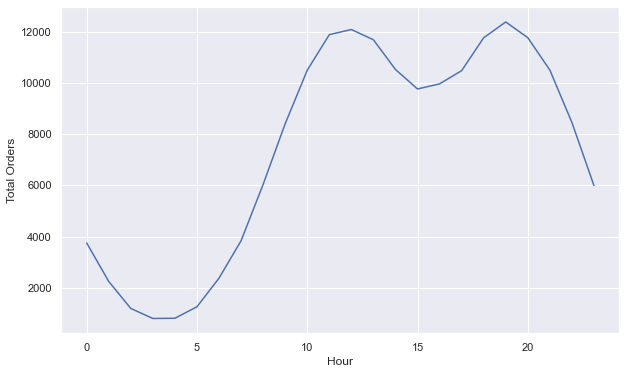

In [35]:
plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.lineplot(x="Hour",y="TotalOrders", data=pd_sales_q3)
plt.ylabel("Total Orders")
plt.show()

### What products are most often sold together in the state of NY?

In [36]:
from pyspark.sql.functions import collect_list, size

In [37]:
sales2019_df.show()

+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|         City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+-------------+-----+-----+
| 295665|  Macbook Pro Laptop|       1|1700.0|2019-12-30 00:01:00|136 Church St, Ne...|New York City|   NY|   12|
| 295666|  LG Washing Machine|       1| 600.0|2019-12-29 07:03:00|562 2nd St, New Y...|New York City|   NY|   12|
| 295667|USB-C Charging Cable|       1| 11.95|2019-12-12 18:21:00|277 Main St, New ...|New York City|   NY|   12|
| 295668|    27in FHD Monitor|       1|149.99|2019-12-22 15:13:00|410 6th St, San F...|San Francisco|   CA|   12|
| 295669|USB-C Charging Cable|       1| 11.95|2019-12-18 12:38:00|43 Hill St, Atlan...|      Atlanta|   GA|   12|
| 295670|AA Batteries (4-p...|       1|  3.84|2019-12-31 22:58:00|200 Jefferson St,...|N

In [38]:
sales_q4_df = (sales2019_df.where(col("State") == "NY")
                           .orderBy("OrderID","Product")
                           .groupBy("OrderID","State")
                           .agg(collect_list("Product").alias("ProductList"))
              )

In [39]:
sales_q4_df.show(10, False)

+-------+-----+------------------------------------------------+
|OrderID|State|ProductList                                     |
+-------+-----+------------------------------------------------+
|141851 |NY   |[27in FHD Monitor]                              |
|142149 |NY   |[AA Batteries (4-pack)]                         |
|142787 |NY   |[Lightning Charging Cable]                      |
|143020 |NY   |[ThinkPad Laptop]                               |
|143862 |NY   |[Apple Airpods Headphones]                      |
|144151 |NY   |[LG Dryer]                                      |
|144851 |NY   |[Apple Airpods Headphones, USB-C Charging Cable]|
|146589 |NY   |[Wired Headphones]                              |
|147784 |NY   |[AAA Batteries (4-pack)]                        |
|148099 |NY   |[27in 4K Gaming Monitor]                        |
+-------+-----+------------------------------------------------+
only showing top 10 rows



In [40]:
sales_q4_df = (sales_q4_df.withColumn("ProductListSize", size("ProductList")))
sales_q4_df.filter(col("ProductListSize") > 1).orderBy("ProductList").show(10, False)

+-------+-----+----------------------------------------+---------------+
|OrderID|State|ProductList                             |ProductListSize|
+-------+-----+----------------------------------------+---------------+
|253929 |NY   |[20in Monitor, 27in 4K Gaming Monitor]  |2              |
|248053 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|197004 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|266247 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|158102 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|176251 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|245465 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|194762 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|234956 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
|204645 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
+-------+-----+------------------------------------

In [41]:
(sales_q4_df.filter(col("ProductListSize") > 1)
            .groupBy("ProductList")
            .count()
            .orderBy("count", ascending=False)
).show(10, False)

+-------------------------------------------------+-----+
|ProductList                                      |count|
+-------------------------------------------------+-----+
|[Google Phone, USB-C Charging Cable]             |127  |
|[Lightning Charging Cable, iPhone]               |126  |
|[Google Phone, Wired Headphones]                 |53   |
|[USB-C Charging Cable, Vareebadd Phone]          |50   |
|[Wired Headphones, iPhone]                       |46   |
|[Apple Airpods Headphones, iPhone]               |45   |
|[Bose SoundSport Headphones, Google Phone]       |24   |
|[Apple Airpods Headphones, Wired Headphones]     |19   |
|[Vareebadd Phone, Wired Headphones]              |17   |
|[AA Batteries (4-pack), Lightning Charging Cable]|16   |
+-------------------------------------------------+-----+
only showing top 10 rows

